# EDA & Predicción (Santander-Kaggle)

Dataset used: Santander Customer Transaction Prediction

https://www.kaggle.com/gpreda/santander-eda-and-prediction

En este desafío, Santander invita a Kagglers a ayudarlos a identificar qué clientes realizarán una transacción específica en el futuro, independientemente de la cantidad de dinero que se tramite. Los datos proporcionados para esta competencia tienen la misma estructura que los datos reales que tienen disponibles para resolver este problema.

Los datos están anonimizados, cada fila contiene 200 valores numéricos identificados solo con un número.

A continuación, exploraremos los datos, los prepararemos para un modelo, entrenaremos un modelo y predeciremos el valor objetivo para el conjunto de pruebas, luego prepararemos un envío.

Estén atentos, frecuentemente se actualizará este Kernel en los próximos días.

Load packages    

In [102]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [104]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="data/Santander/"
else:
    PATH="data/Santander/"
os.listdir(PATH)

['sample_submission.csv',
 'submission.csv',
 'test',
 'test.csv',
 'train',
 'train.csv']

In [105]:
#%%time
df_train = pd.read_csv(PATH+"train.csv")
df_test = pd.read_csv(PATH+"test.csv")

In [106]:
df_train.shape, df_test.shape

((200000, 202), (200000, 201))

In [107]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [108]:
df_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Train contains:
ID_code (string);
target;
200 numerical variables, named from var_0 to var_199;

Test contains:
ID_code (string);
200 numerical variables, named from var_0 to var_199;

In [109]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [110]:
%%time
missing_data(df_train)

Wall time: 1.51 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [111]:
%%time
missing_data(df_test)

Wall time: 1.44 s


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [112]:
%%time
df_train.describe()

Wall time: 1.91 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [113]:
%time
df_test.describe()

Wall time: 0 ns


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400



Aquí podemos hacer algunas observaciones:

La desviación estándar es relativamente grande para los datos de variables de tren y de prueba;
Los valores mínimo, máximo, medio, sdt para el tren y los datos de prueba parecen bastante cercanos;
los valores medios se distribuyen en un amplio rango.
El número de valores en tren y conjunto de pruebas es el mismo. Vamos a trazar el diagrama de dispersión para el tren y el conjunto de prueba para algunas de las características.

In [114]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

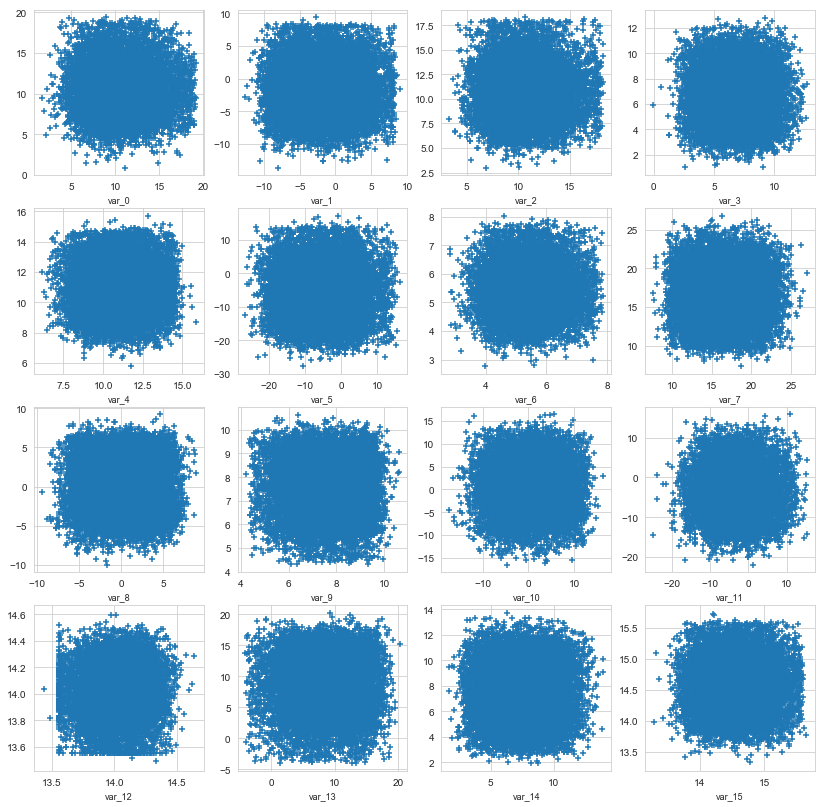

In [115]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15',]

plot_feature_scatter(df_train[::20], df_test[::20], features)

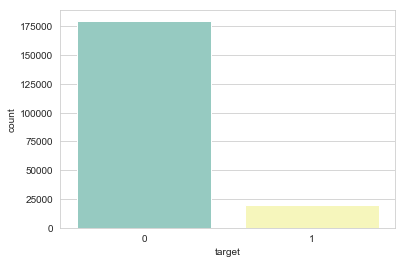

In [116]:
sns.countplot(df_train['target'], palette='Set3')

In [117]:
print("Hay {}% valores objetivo con 1" .format (100 * df_train ["target"]. value_counts () [1] /df_train.shape [0]))

Hay 10.049% valores objetivo con 1


Los datos están desequilibrados con respecto al valor objetivo.

CARACTERISTICAS de DENSIDAD de las PARCELAS

Vamos a mostrar ahora la gráfica de densidad de las variables en el conjunto de datos del tren.

Representamos con diferentes colores la distribución de valores con valores objetivo 0 y 1.

In [118]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

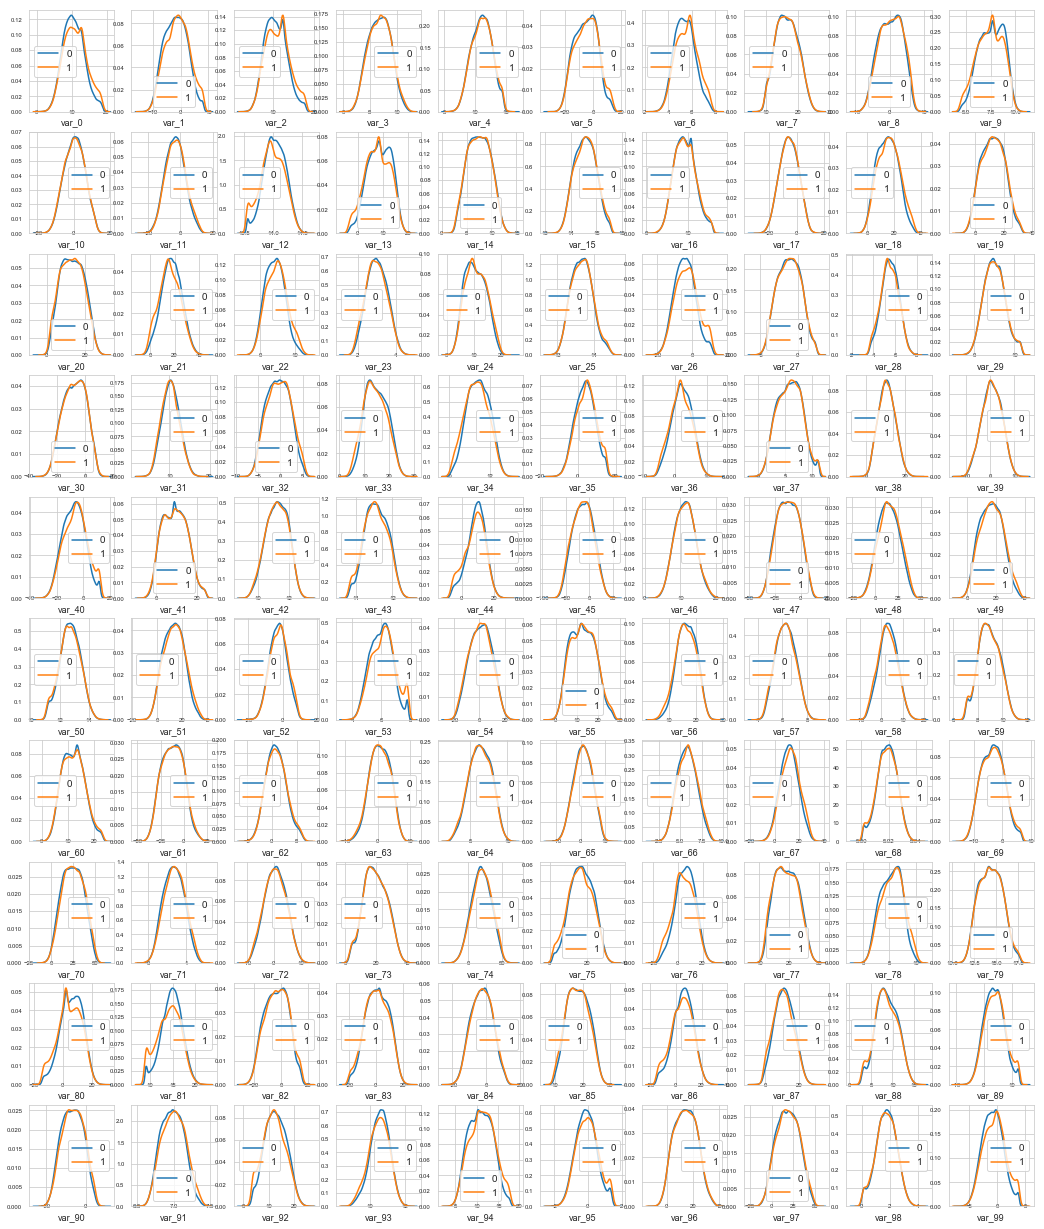

In [119]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

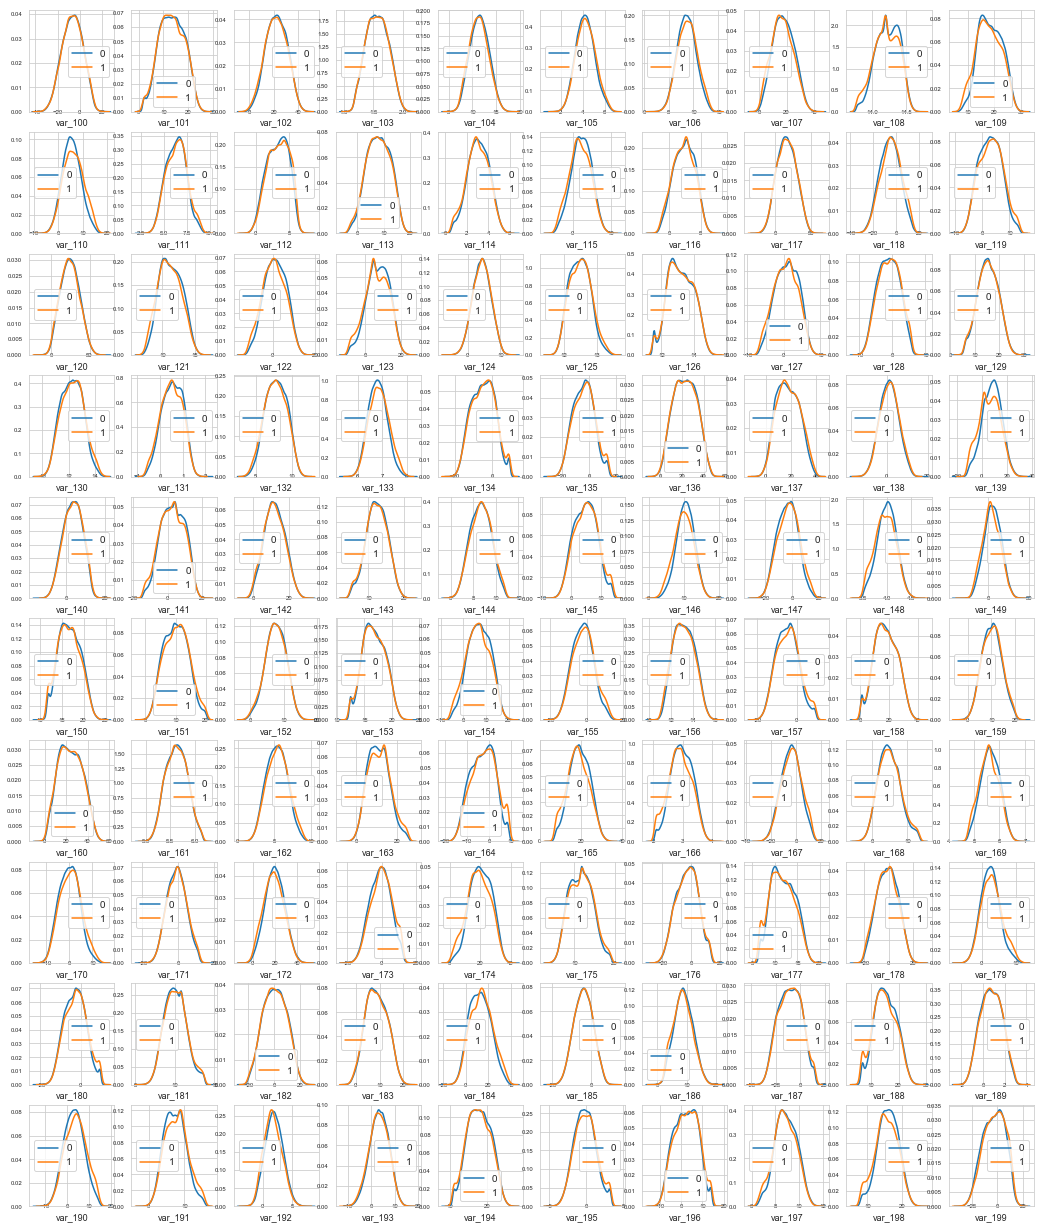

In [120]:
features = df_train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)


Podemos observar que hay un número considerable de características con una distribución significativamente diferente para los dos valores objetivo.
Por ejemplo, var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139 y muchos otros.

También algunas características, como var_2, var_13, var_26, var_55, var_175, var_184, var_196 muestra una distribución que se remite a una distribución bivariada.

En el futuro, lo tendremos en cuenta para la selección de las características de nuestro modelo de predicción.

Ahora no busque la distribución de las mismas características en paralelo en los conjuntos de datos de prueba y de tren.

Los primeros 100 valores se muestran en la siguiente celda.

<Figure size 432x288 with 0 Axes>

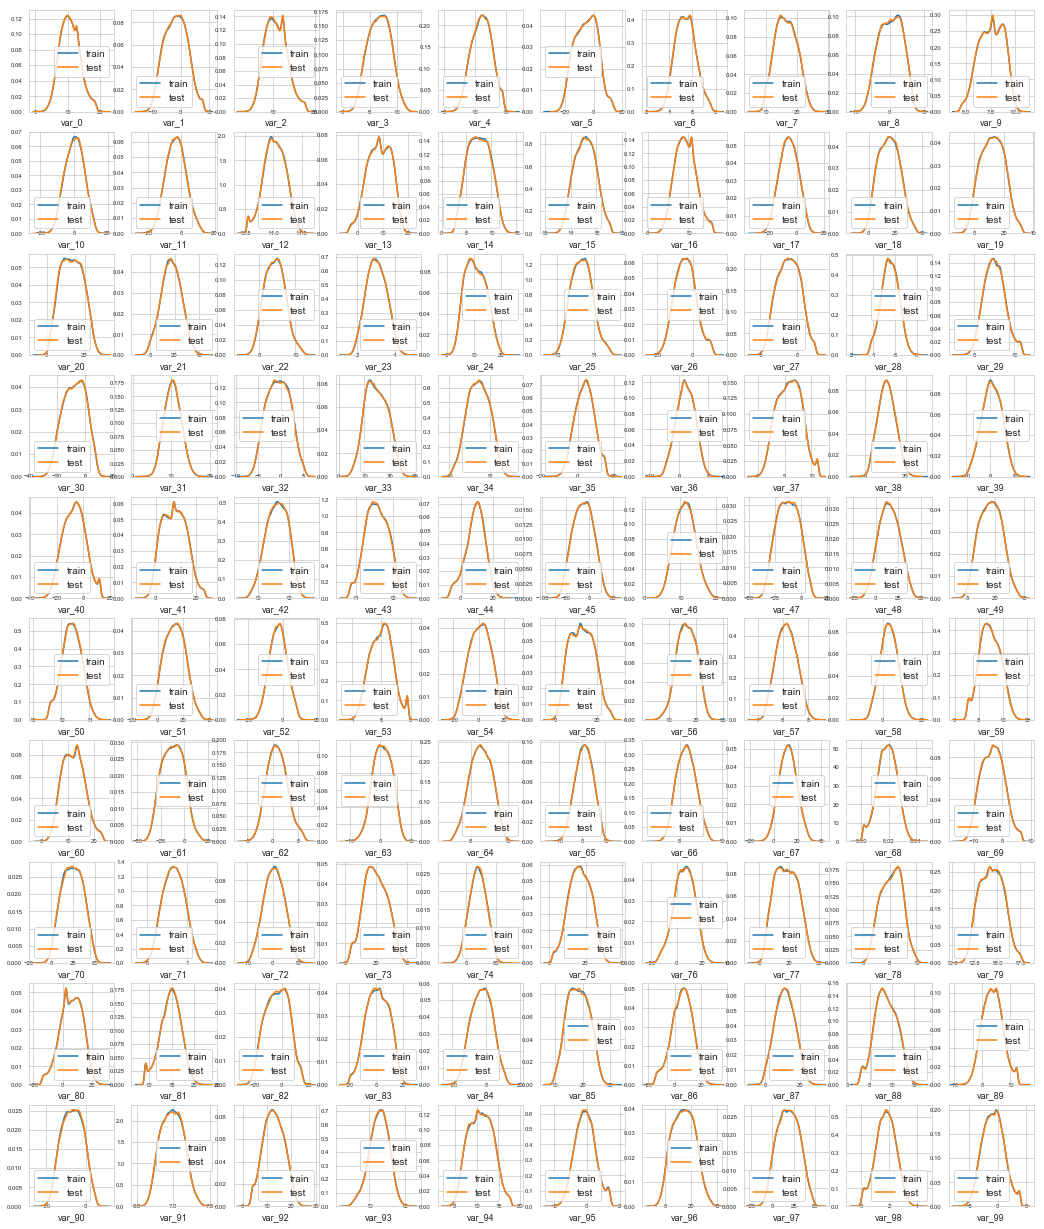

In [121]:
features = df_train.columns.values[2:102]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

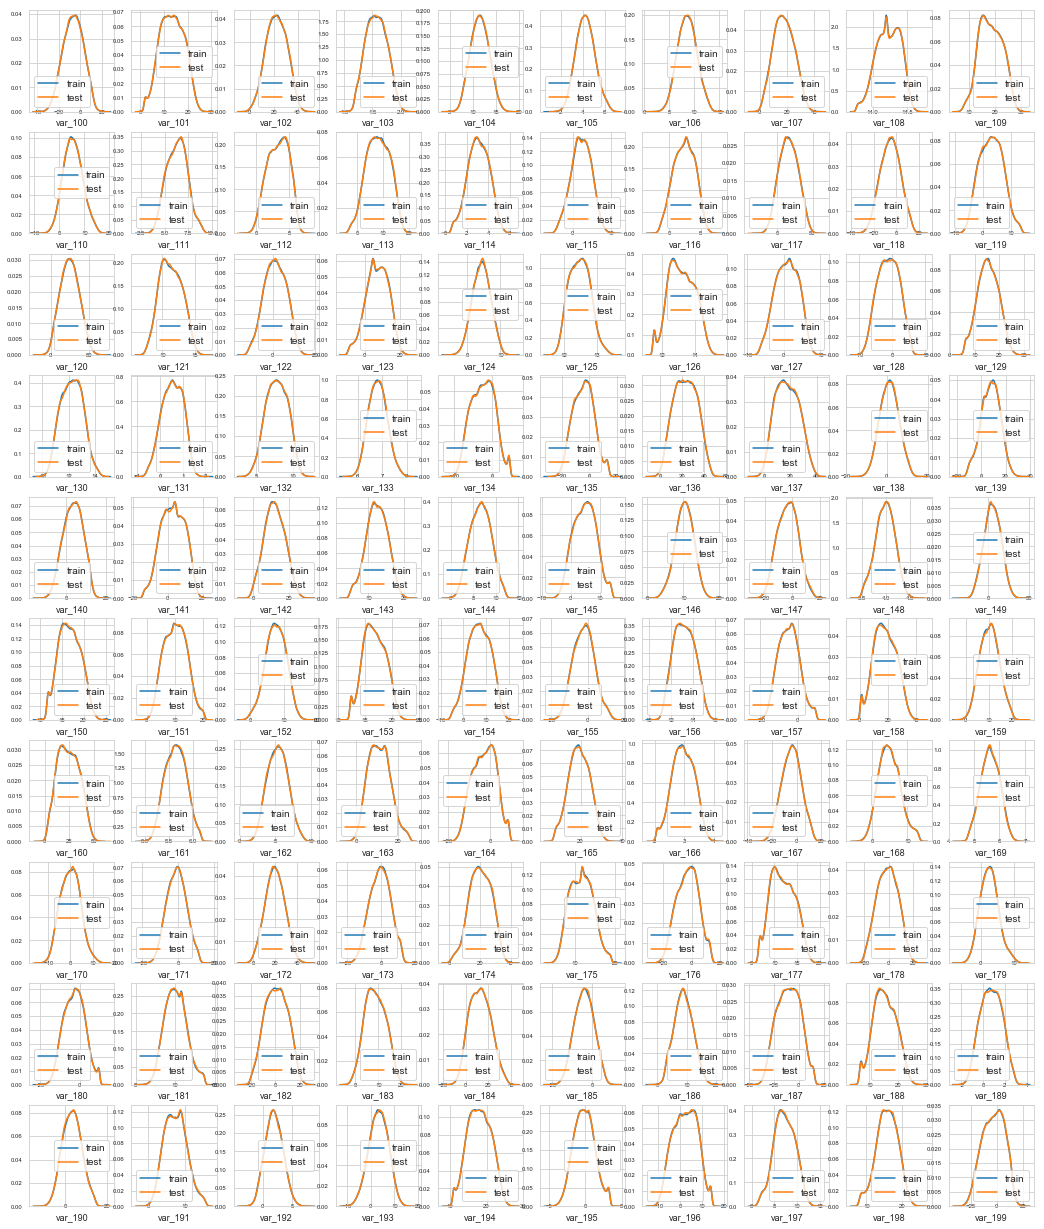

In [122]:
features = df_train.columns.values[102:202]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

El tren y la prueba parecen estar bien equilibrados con respecto a la distribución de las variables numéricas.

Distribución de media y estándar.

Revisemos la distribución de los valores medios por fila en el tren y el conjunto de pruebas.

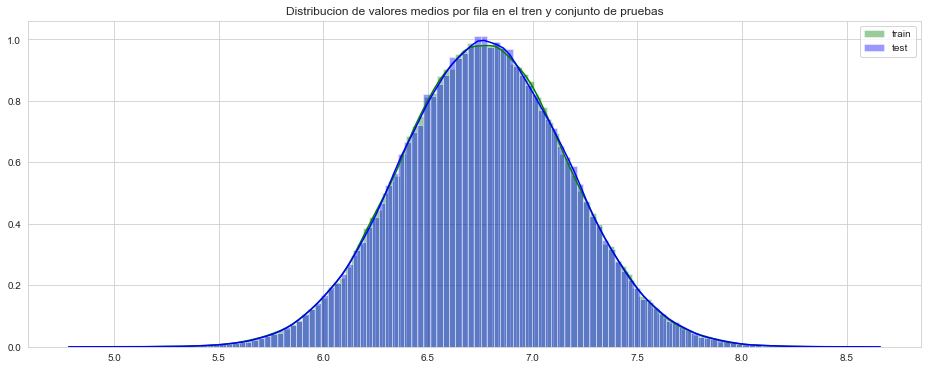

In [123]:
plt.figure(figsize=(16,6))
features = df_train.columns.values[2:202]
plt.title("Distribucion de valores medios por fila en el tren y conjunto de pruebas")
sns.distplot(df_train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(df_test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Revisemos la distribución de los valores medios por columnas en el conjunto de prueba y tren.

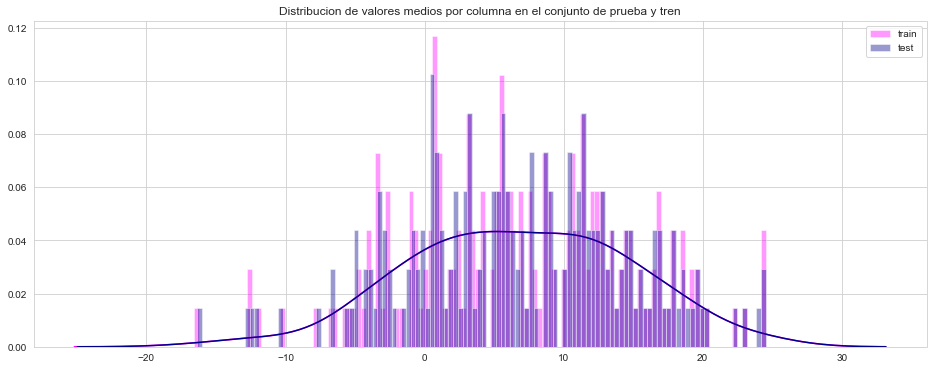

In [124]:
plt.figure(figsize=(16,6))
plt.title("Distribucion de valores medios por columna en el conjunto de prueba y tren")
sns.distplot(df_train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(df_test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Vamos a mostrar la distribución de la desviación estándar de los valores por fila para los conjuntos de datos de prueba y tren.

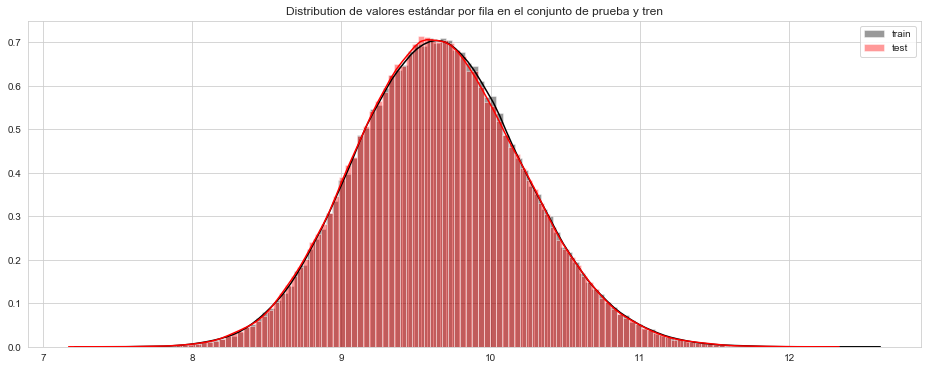

In [125]:
plt.figure(figsize=(16,6))
plt.title("Distribution de valores estándar por fila en el conjunto de prueba y tren")
sns.distplot(df_train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(df_test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Revisemos la distribución de la desviación estándar de los valores por columnas en los conjuntos de datos de tren y de prueba.

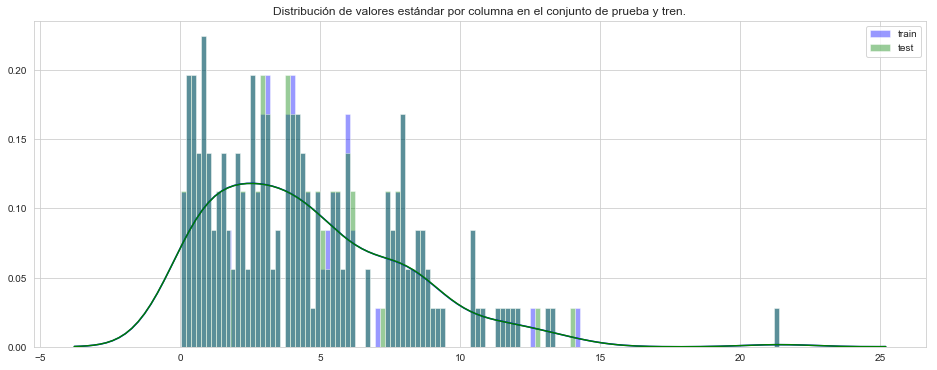

In [126]:
plt.figure(figsize=(16,6))
plt.title("Distribución de valores estándar por columna en el conjunto de prueba y tren.")
sns.distplot(df_train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(df_test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

Revisemos ahora la distribución del valor medio por fila en el conjunto de datos del tren, agrupados por el valor del objetivo.

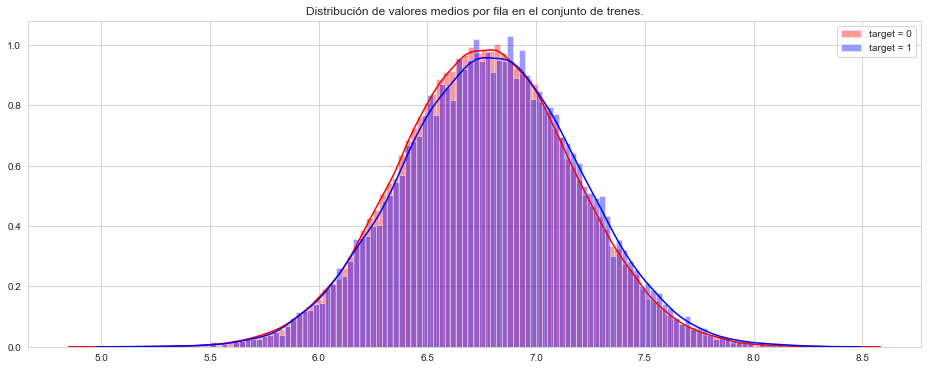

In [127]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribución de valores medios por fila en el conjunto de trenes.")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Revisemos ahora la distribución del valor medio por columna en el conjunto de datos del tren, agrupados por el valor del objetivo.

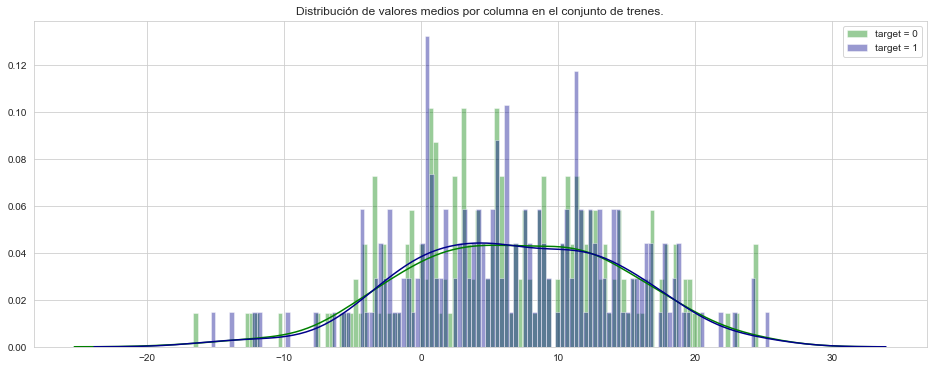

In [128]:
plt.figure(figsize=(16,6))
plt.title("Distribución de valores medios por columna en el conjunto de trenes.")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Distribución de mín y máx.

Revisemos la distribución de minutos por fila en el tren y el conjunto de pruebas.

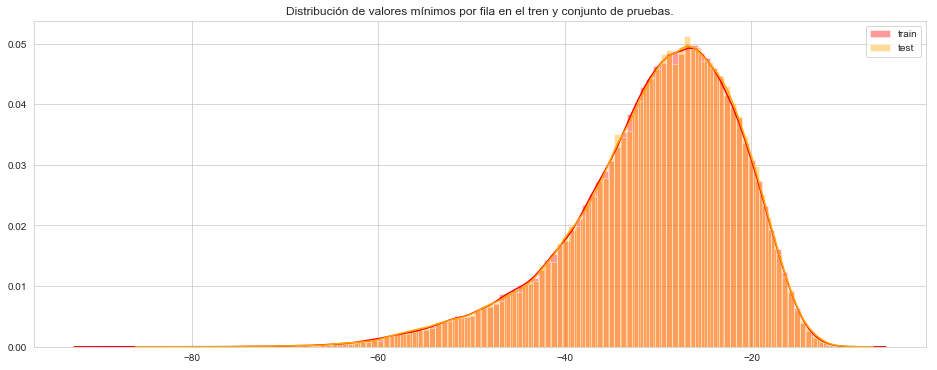

In [129]:
plt.figure(figsize=(16,6))
features = df_train.columns.values[2:202]
plt.title("Distribución de valores mínimos por fila en el tren y conjunto de pruebas.")
sns.distplot(df_train[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(df_test[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Se observa una larga cola a los valores más bajos para ambos, extendida hasta -80 para el conjunto de pruebas.

Ahora vamos a mostrar la distribución de min por columna en el conjunto de prueba y tren.

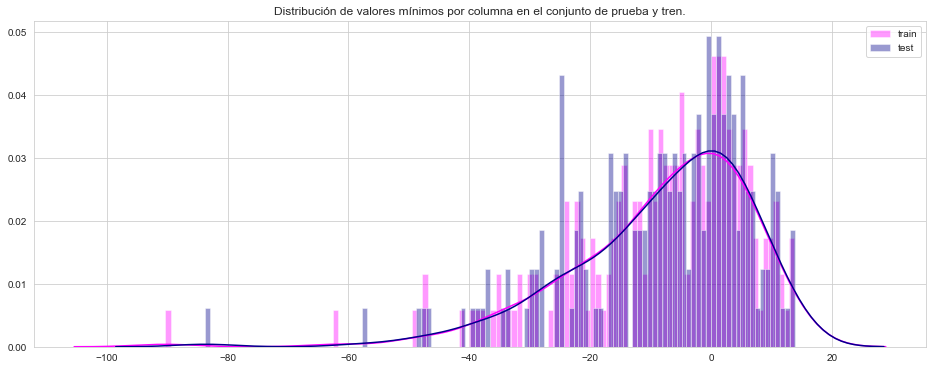

In [130]:
plt.figure(figsize=(16,6))
features = df_train.columns.values[2:202]
plt.title("Distribución de valores mínimos por columna en el conjunto de prueba y tren.")
sns.distplot(df_train[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(df_test[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Revisemos ahora la distribución de valores máximos por filas para el tren y el conjunto de pruebas.

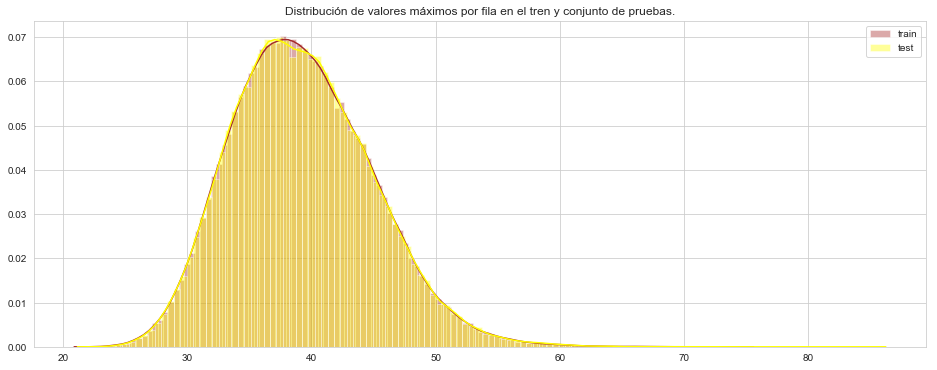

In [131]:
plt.figure(figsize=(16,6))
features = df_train.columns.values[2:202]
plt.title("Distribución de valores máximos por fila en el tren y conjunto de pruebas.")
sns.distplot(df_train[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(df_test[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Mostremos ahora la distribución máxima en columnas para tren y conjunto de prueba

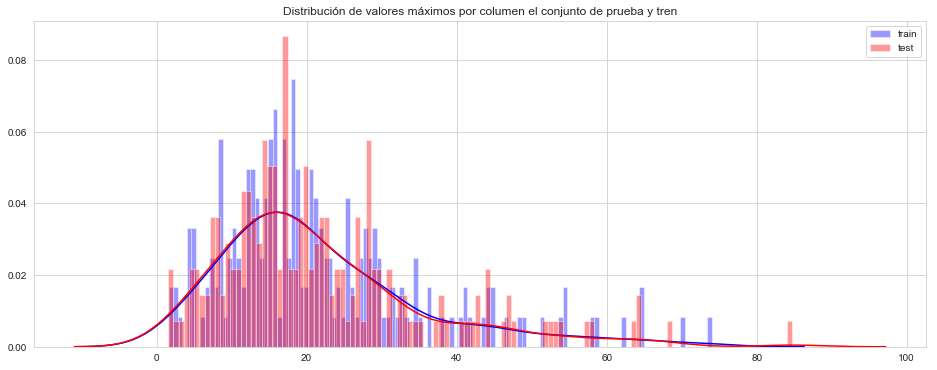

In [132]:
plt.figure(figsize=(16,6))
features = df_train.columns.values[2:202]
plt.title("Distribución de valores máximos por columen el conjunto de prueba y tren")
sns.distplot(df_train[features].max(axis=0),color="blue", kde=True, bins=120, label='train')
sns.distplot(df_test[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Mostremos ahora las distribuciones de valores mínimos por fila en el conjunto de trenes, separados en los valores de destino (0 y 1).

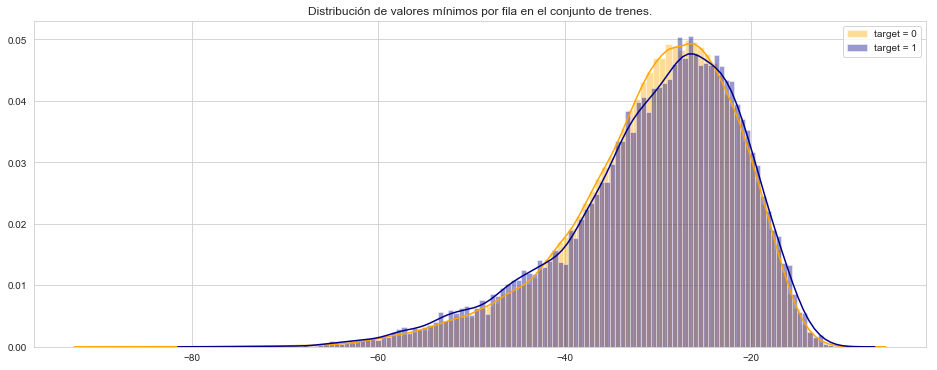

In [133]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribución de valores mínimos por fila en el conjunto de trenes.")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Aquí mostramos la distribución de valores mínimos por columnas en el conjunto de trenes

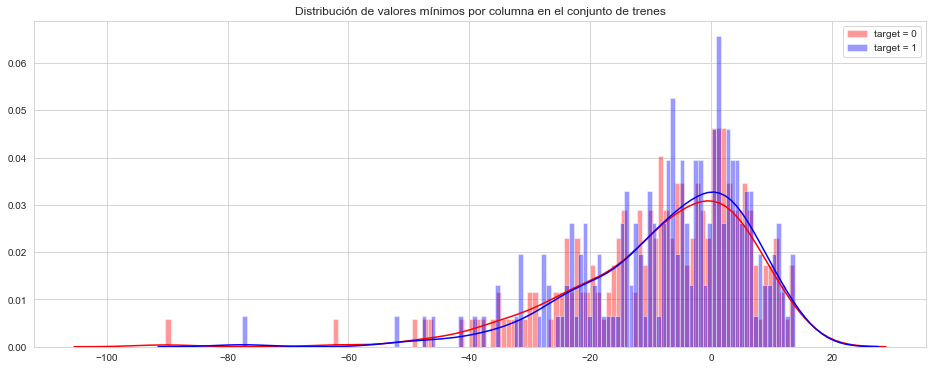

In [134]:
plt.figure(figsize=(16,6))
plt.title("Distribución de valores mínimos por columna en el conjunto de trenes")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

Vamos a mostrar ahora la distribución de los valores máximos por rown en el conjunto de trenes.

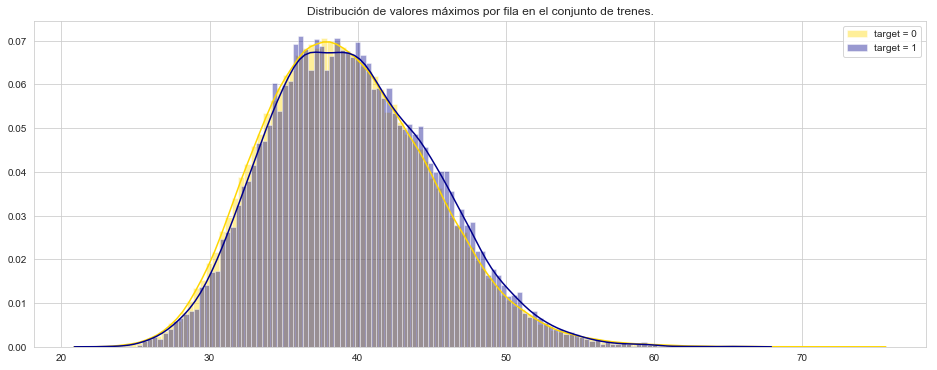

In [135]:
plt.figure(figsize=(16,6))
plt.title("Distribución de valores máximos por fila en el conjunto de trenes.")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Mostremos también la distribución de valores máximos por columnas en el conjunto de trenes.

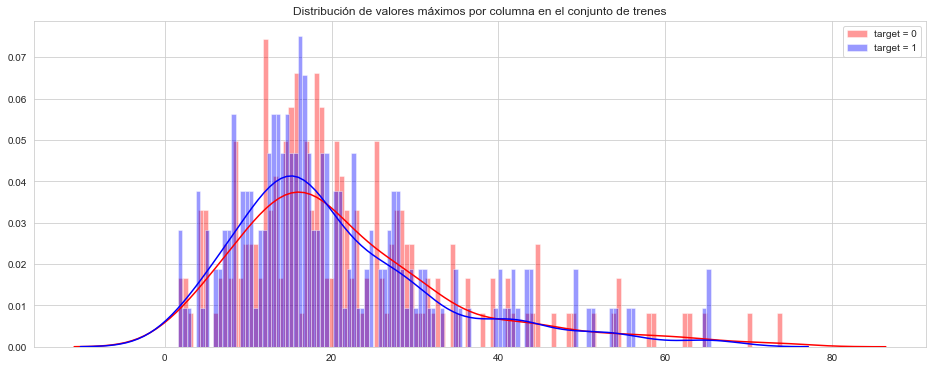

In [136]:
plt.figure(figsize=(16,6))
plt.title("Distribución de valores máximos por columna en el conjunto de trenes")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

DISTRIBUCION de SESGO y KURTOSIS.

Veamos ahora cuál es la distribución de los valores de sesgo por filas y columnas.

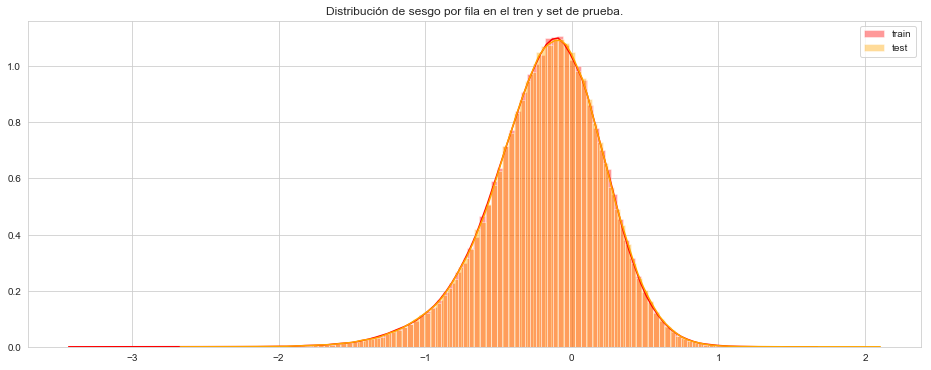

In [137]:
plt.figure(figsize=(16,6))
plt.title("Distribución de sesgo por fila en el tren y set de prueba.")
sns.distplot(df_train[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(df_test[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Veamos la distribución de la asimetría calculada por columnas en el conjunto de prueba y tren.

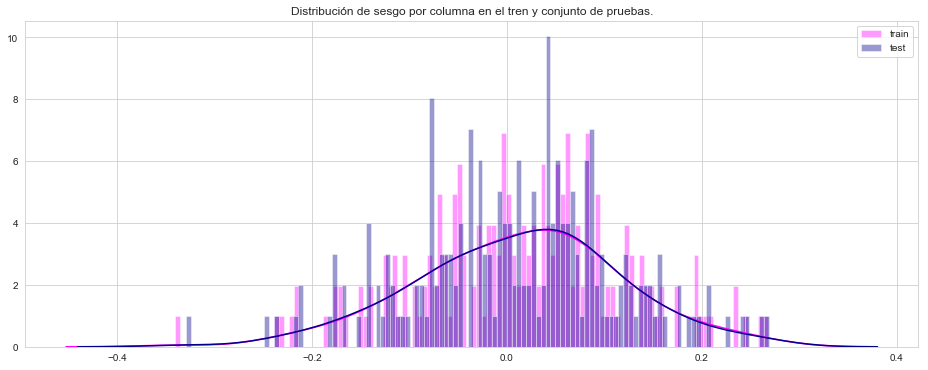

In [138]:
plt.figure(figsize=(16,6))
plt.title("Distribución de sesgo por columna en el tren y conjunto de pruebas.")
sns.distplot(df_train[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(df_test[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Veamos ahora cuál es la distribución de los valores de curtosis por filas y columnas.

Veamos primero la distribución de la curtosis calculada por filas en los conjuntos de pruebas y trenes.

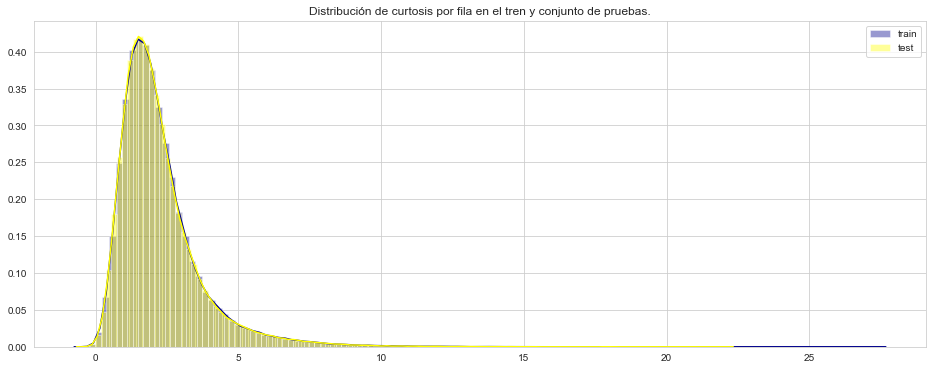

In [139]:
plt.figure(figsize=(16,6))
plt.title("Distribución de curtosis por fila en el tren y conjunto de pruebas.")
sns.distplot(df_train[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(df_test[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Veamos primero la distribución de la curtosis calculada por columnas en los conjuntos de prueba y tren.

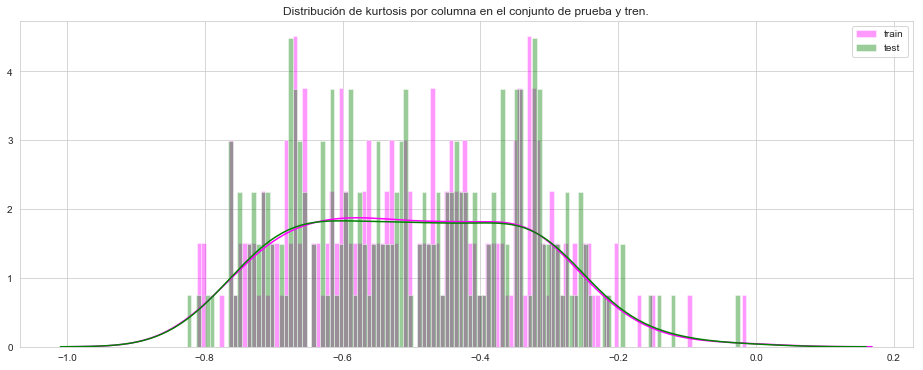

In [140]:
plt.figure(figsize=(16,6))
plt.title("Distribución de kurtosis por columna en el conjunto de prueba y tren.")
sns.distplot(df_train[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(df_test[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Veamos ahora la distribución de la asimetría en filas en tren separadas para los valores de destino 0 y 1.

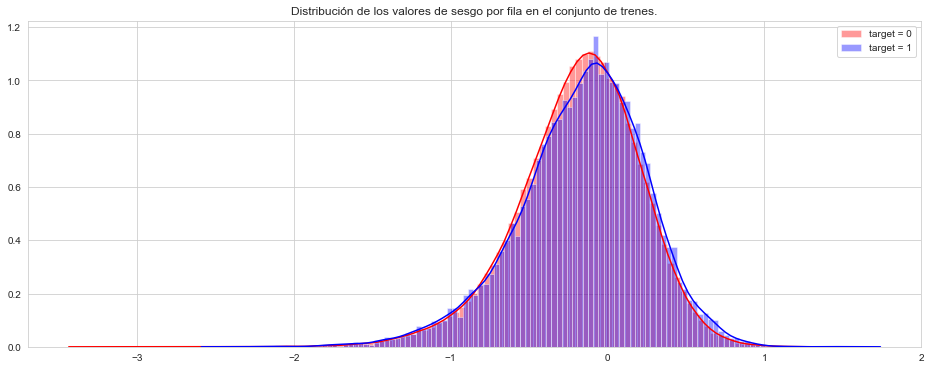

In [141]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribución de los valores de sesgo por fila en el conjunto de trenes.")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Veamos ahora la distribución de la asimetría en columnas en tren separadas para los valores de destino 0 y 1.

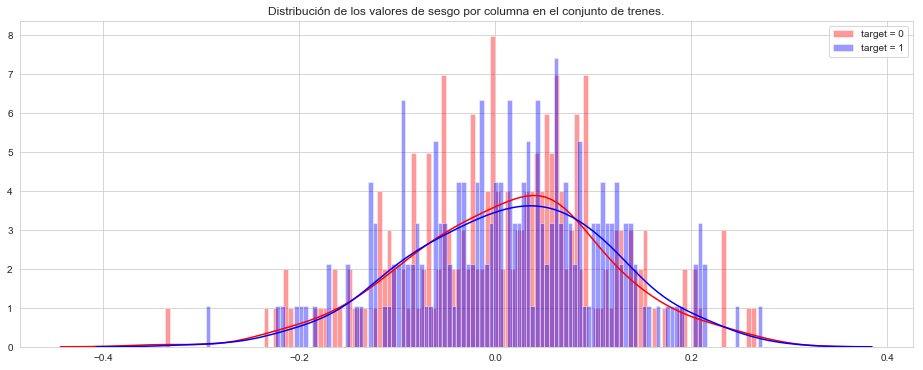

In [142]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribución de los valores de sesgo por columna en el conjunto de trenes.")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Veamos ahora la distribución de la curtosis en filas en tren separadas para los valores de destino 0 y 1.

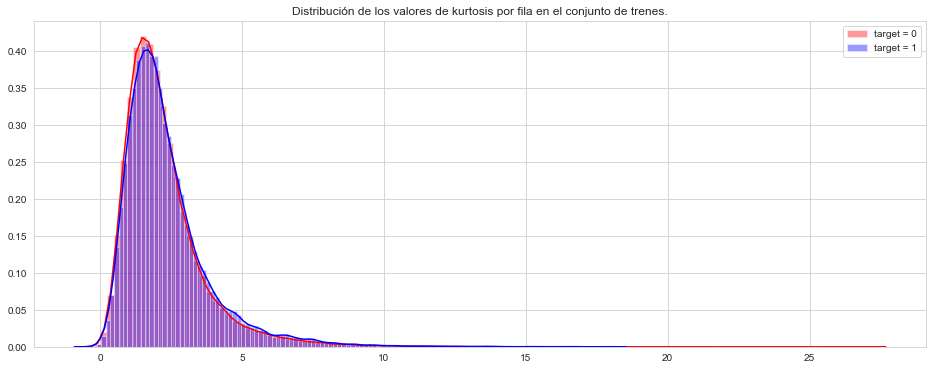

In [143]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribución de los valores de kurtosis por fila en el conjunto de trenes.")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Veamos ahora la distribución de la curtosis en columnas en tren separadas para los valores de destino 0 y 1.

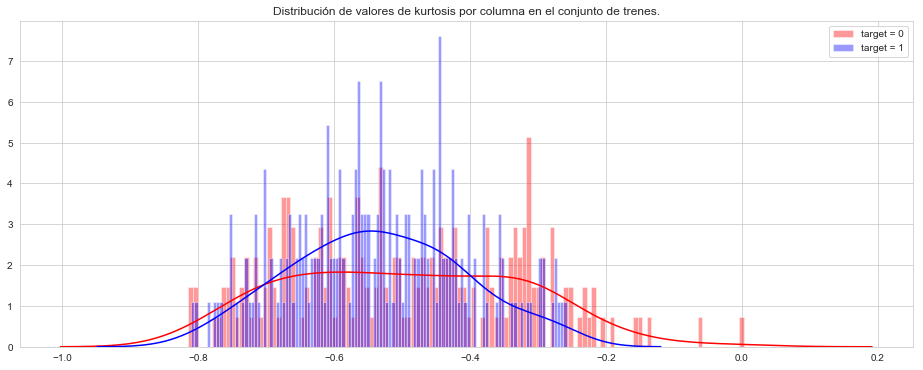

In [144]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribución de valores de kurtosis por columna en el conjunto de trenes.")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

CARACTERISTICAS de CORRELACION

Calculamos ahora las correlaciones entre las características en el conjunto de trenes.
La siguiente tabla muestra las 10 primeras características menos correlacionadas.

In [145]:
correlations = df_train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


Veamos las características más correlacionadas, además de los mismos pares de funciones

In [146]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


La correlación entre las características es muy pequeña.

VALORES DUPLICADOS

Veamos ahora cuántos valores duplicados existen por columnas.

In [147]:
#%%time
features = df_train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = df_train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = df_test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Vamos a mostrar el top 15 máximo de valores duplicados por conjunto de trenes.

In [148]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


Veamos también el top 15 número de valores de duplicados por conjunto de pruebas.

In [149]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


Las mismas columnas en el tren y en el conjunto de pruebas tienen el mismo número de duplicados de valores iguales o muy cercanos. Este es un patrón interesante que podríamos usar en el futuro.

In [150]:
%%time
idx = features = df_train.columns.values[2:202]
for df in [df_test, df_train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

Wall time: 14.4 s


Vamos a comprobar las nuevas características creadas

In [151]:
df_train[df_train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [152]:
df_test[df_test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [153]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

Revisemos la distribución de estas nuevas características de ingeniería.

Primero trazamos la distribución de las nuevas características, agrupadas por el valor de los valores objetivo correspondientes.

<Figure size 432x288 with 0 Axes>

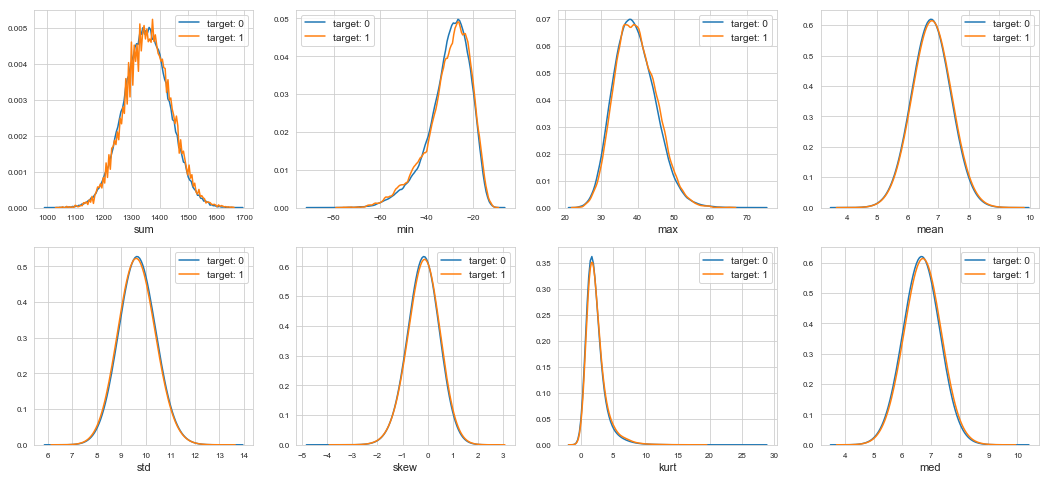

In [154]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Vamos a mostrar la distribución de los nuevos valores de características para entrenar y probar.

<Figure size 432x288 with 0 Axes>

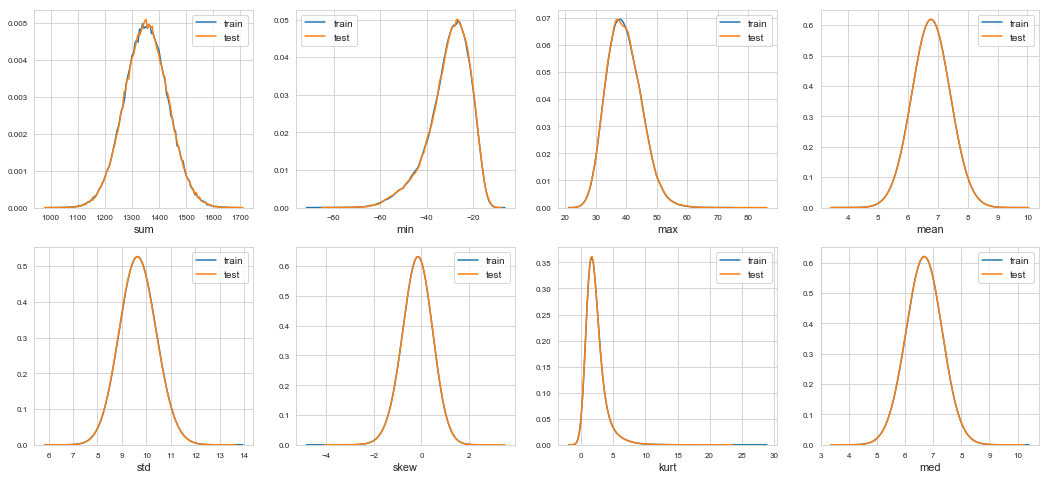

In [155]:
features = df_train.columns.values[202:]
plot_new_feature_distribution(df_train, df_test, 'train', 'test', features)

Añadimos características redondeadas.
Nota: este es un trabajo en progreso, algunas de las características agregadas aquí se eliminarán más adelante.

In [156]:
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]
for feature in features:
    df_train['r2_'+feature] = np.round(df_train[feature], 2)
    df_test['r2_'+feature] = np.round(df_test[feature], 2)
    df_train['r1_'+feature] = np.round(df_train[feature], 1)
    df_test['r1_'+feature] = np.round(df_test[feature], 1)

Vamos a ver cuántas características tenemos ahora.

In [157]:
print('Train and test columns: {} {}'.format(len(df_train.columns), len(df_test.columns)))

Train and test columns: 626 625


# MODELO

Desde la lista de columnas del tren, eliminamos el ID y el destino para formar la lista de características.

In [158]:
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]
target = df_train['target']

Definimos los hiperparámetros para el modelo.

In [159]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

Corremos el MODELO

In [161]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.884593	valid_1's auc: 0.864302
[2000]	training's auc: 0.909577	valid_1's auc: 0.884306
[3000]	training's auc: 0.921215	valid_1's auc: 0.892392
[4000]	training's auc: 0.928585	valid_1's auc: 0.896331
[5000]	training's auc: 0.934231	valid_1's auc: 0.898241
[6000]	training's auc: 0.939131	valid_1's auc: 0.899085
[7000]	training's auc: 0.943649	valid_1's auc: 0.89976
[8000]	training's auc: 0.947883	valid_1's auc: 0.899938
[9000]	training's auc: 0.951994	valid_1's auc: 0.900004
[10000]	training's auc: 0.95586	valid_1's auc: 0.900046
[11000]	training's auc: 0.959487	valid_1's auc: 0.899967
Early stopping, best iteration is:
[8822]	training's auc: 0.951261	valid_1's auc: 0.900092
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.885063	valid_1's auc: 0.865174
[2000]	training's auc: 0.909539	valid_1's auc: 0.884678
[3000]	training's auc: 0.921045	valid_1

Vamos a ver la importancia de la característica.

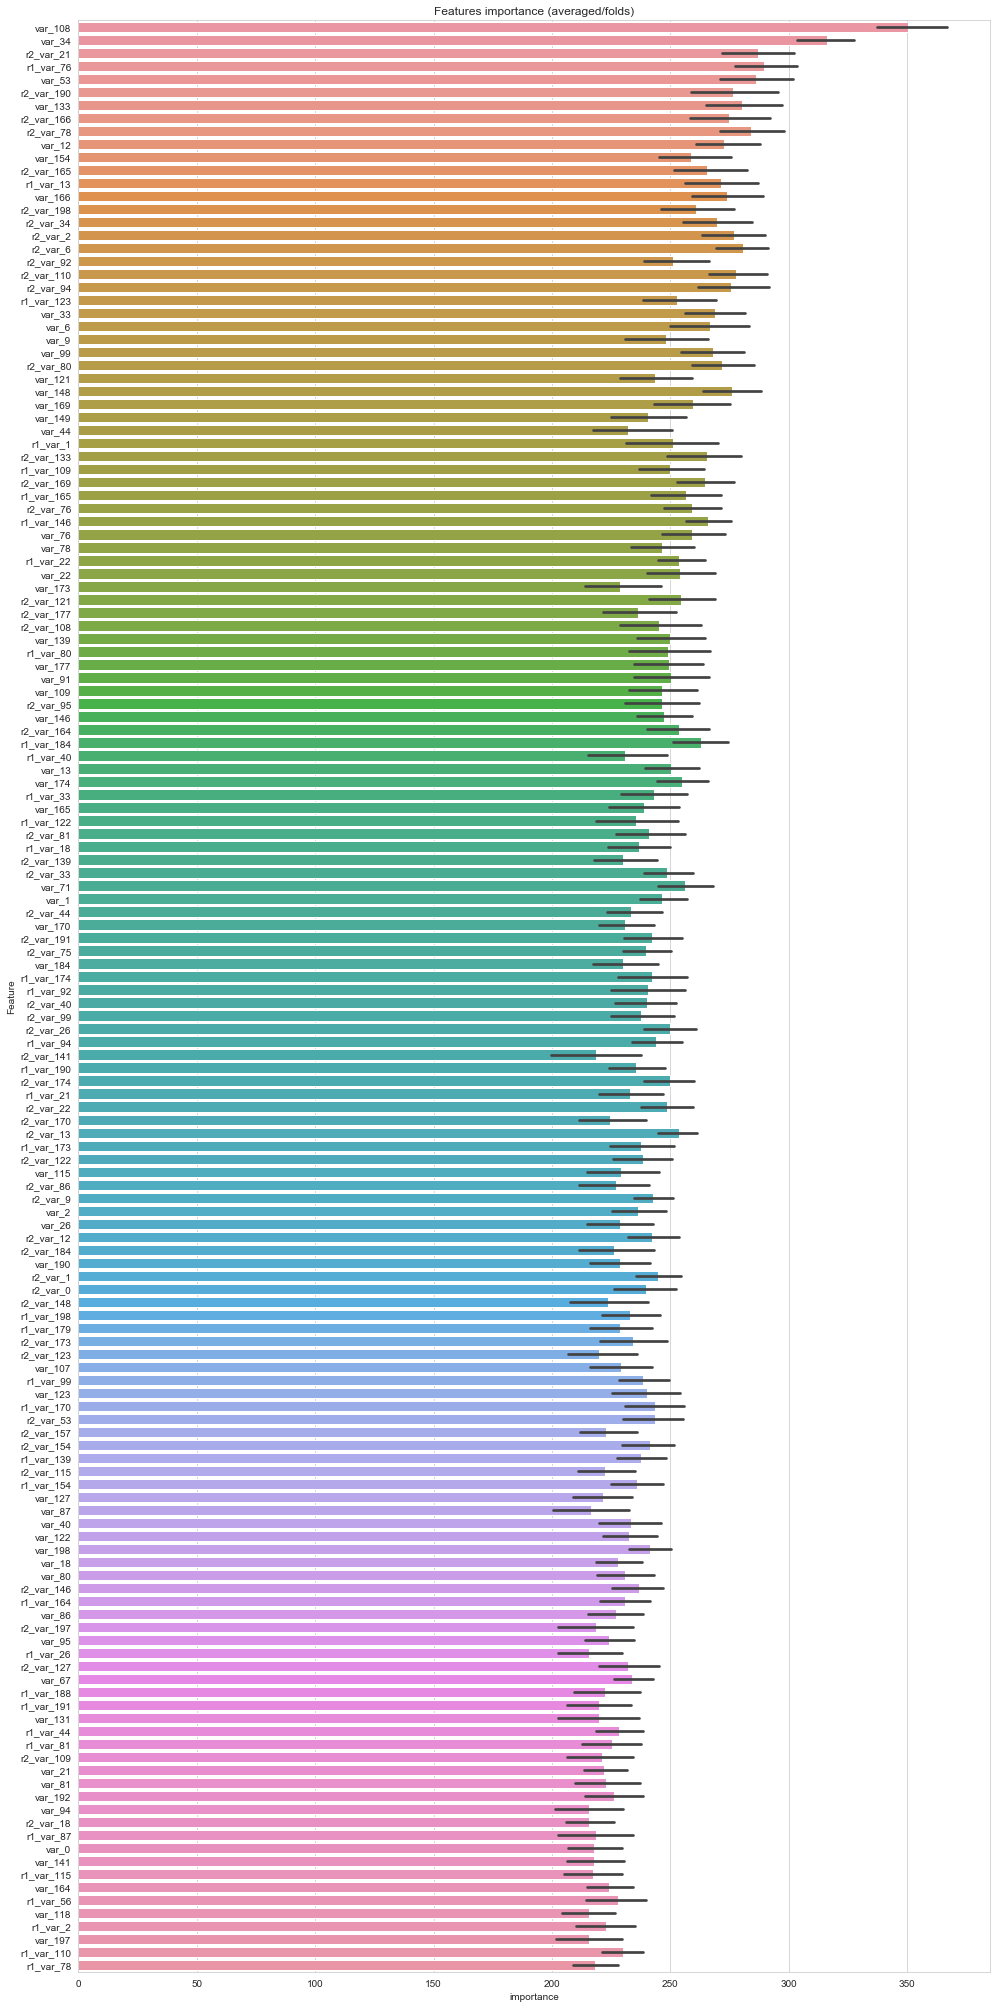

In [163]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [164]:
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("data/Santander/submission.00.csv", index=False)